In [1]:
import os
import sys
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from platypus import Problem, EpsNSGAII, Real, ProcessPoolEvaluator
import csv
import logging
from itertools import chain

logging.basicConfig(level=logging.INFO)
plt.rcParams["figure.figsize"] = [12, 8]
# sys.path.append('..')

In [2]:
sys.path.append(os.path.abspath(".."))
from susquehanna_model import SusquehannaModel
import rbf_functions

In [18]:
rbfs = [
    rbf_functions.squared_exponential_rbf,
    rbf_functions.original_rbf,
    rbf_functions.inverse_quadratic_rbf,
    rbf_functions.inverse_multiquadric_rbf,
    rbf_functions.exponential_rbf,
    rbf_functions.matern32_rbf,
    rbf_functions.matern52_rbf,
]

reference_sets = {}
for entry in rbfs:
    name = entry.__name__
    reference_sets[name] = pd.read_csv(
        os.path.join("./refsets", f"{name}_refset_with_variables.csv")
    )


for filename in os.listdir("../data1999"):
    if filename.startswith("w"):
        globals()[f"{filename[:-4]}"] = np.loadtxt(f"../data1999/{filename}")
    elif filename == "min_flow_req.txt":
        globals()[f"{filename[:-4]}"] = np.loadtxt(
            os.path.join("../data1999", filename)
        )
    elif filename == "salinity_min_flow_req.txt":
        globals()[f"{filename[:-4]}"] = np.loadtxt(
            os.path.join("../data1999", filename)
        )

In [19]:
entry = rbfs[0]
reference_set = reference_sets[entry.__name__]

# setup the RBF network
n_inputs = 2  # (time, storage of Conowingo)
n_outputs = 4  # Atomic, Baltimore, Chester, Downstream:- (hydropower, environmental)
n_rbfs = n_inputs + 2
rbf = rbf_functions.RBF(n_rbfs, n_inputs, n_outputs, rbf_function=entry)

# Initialize model
nobjs = 6
n_years = 1
susquehanna_river = SusquehannaModel(
    108.5, 505.0, 5, n_years, rbf
)  # l0, l0_MR, d0, years
# l0 = start level cono, l0_MR = start level muddy run, d0 = startday > friday = 5

susquehanna_river.set_log(True)

output = []
# iterate over solutions
for _, row in reference_set.iloc[0:10, 0:32].iterrows():
    output.append(susquehanna_river.evaluate(row))

In [20]:
level_CO, level_MR, ratom, rbalt, rches, renv = susquehanna_river.get_log()

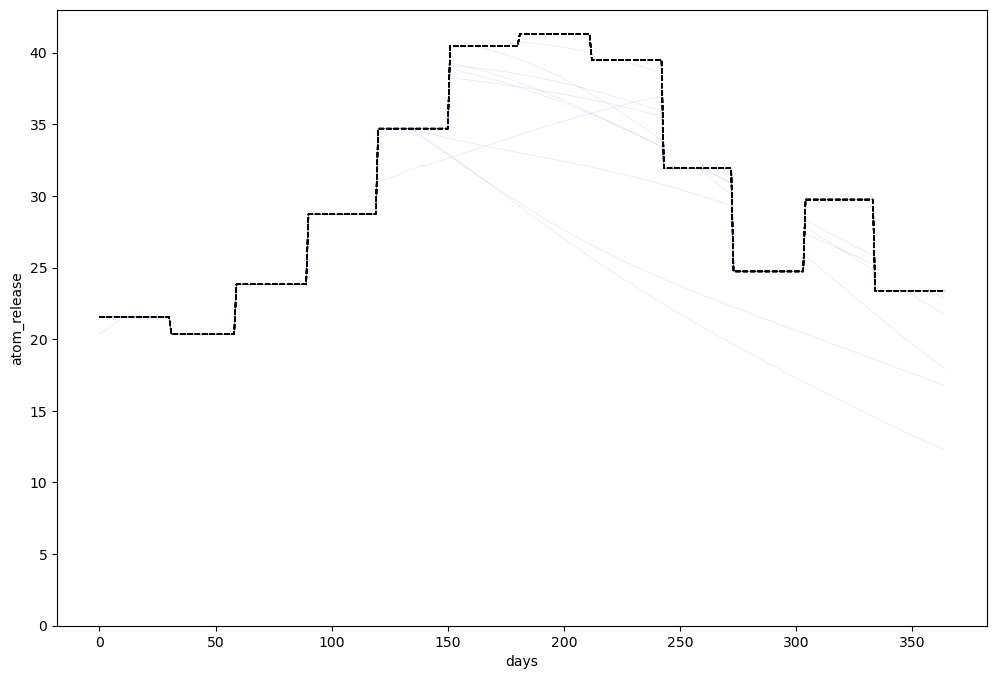

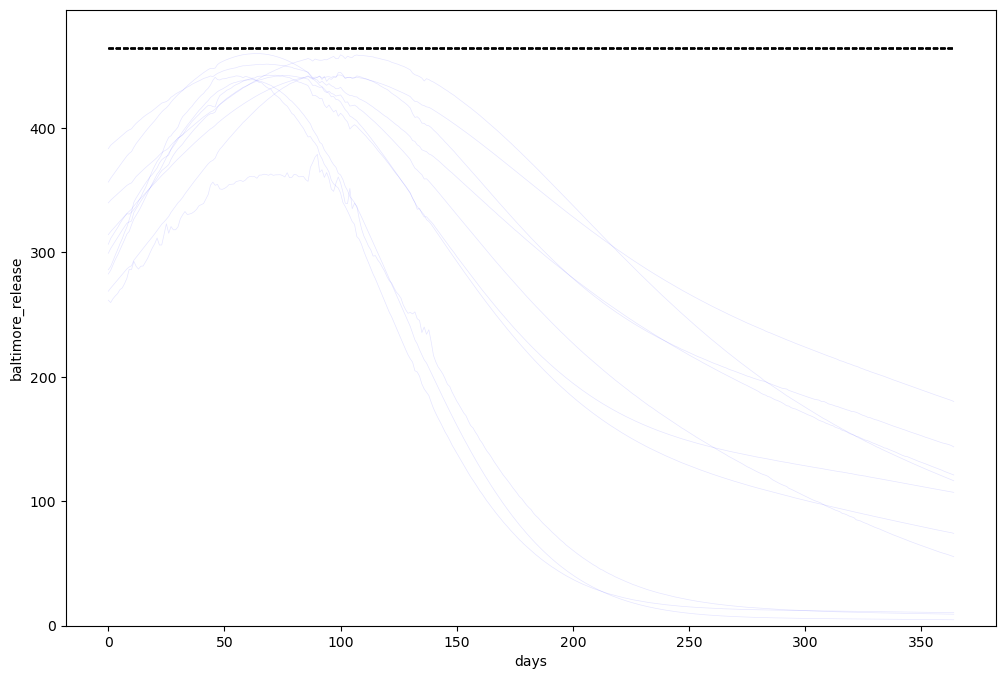

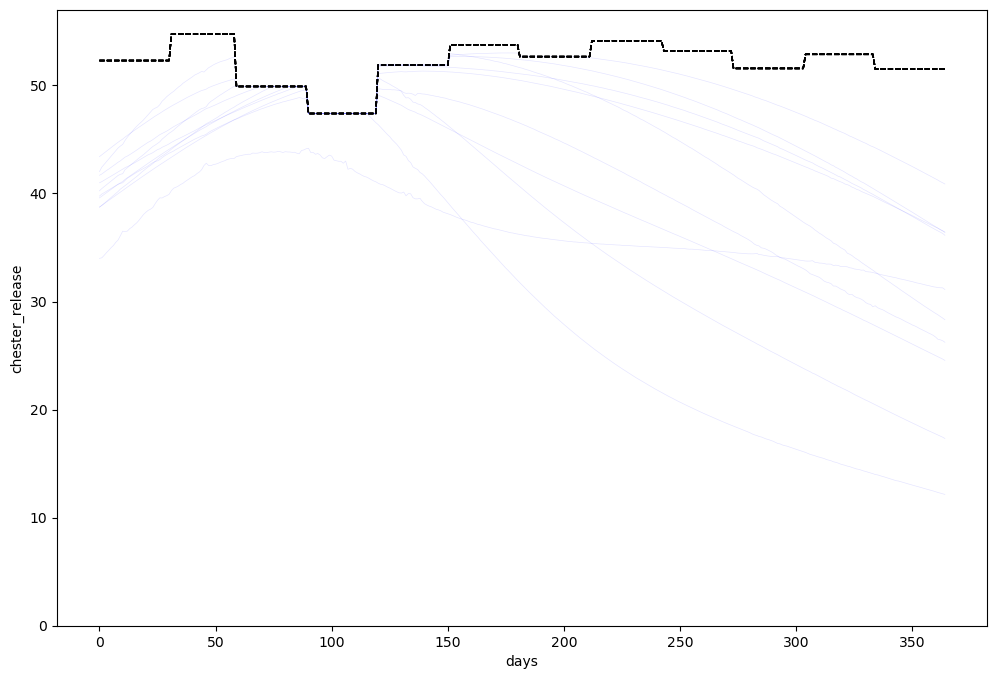

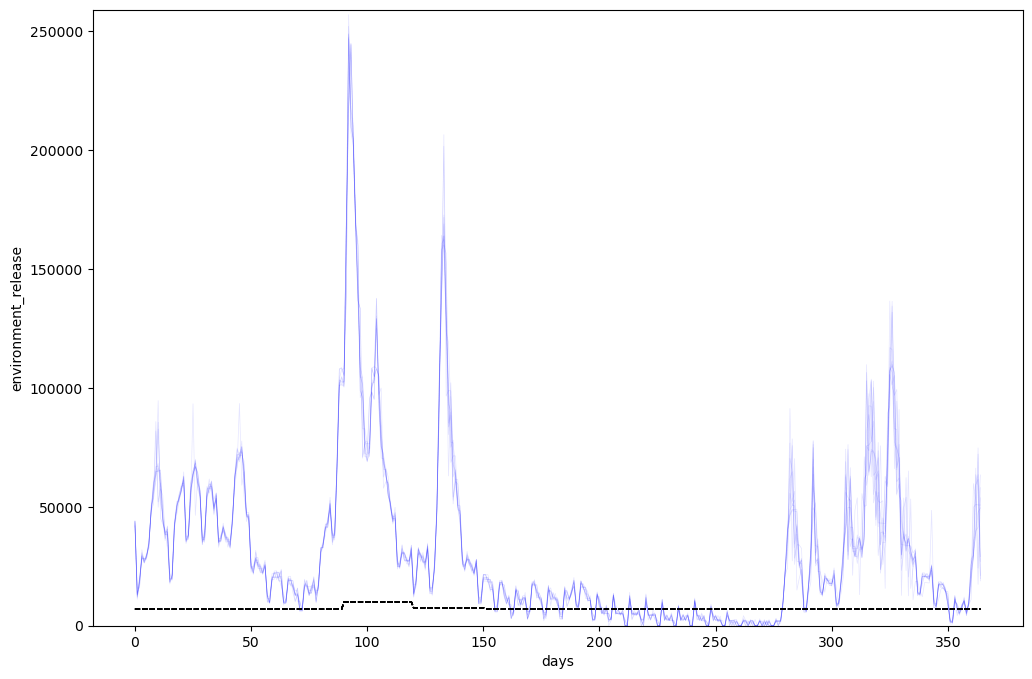

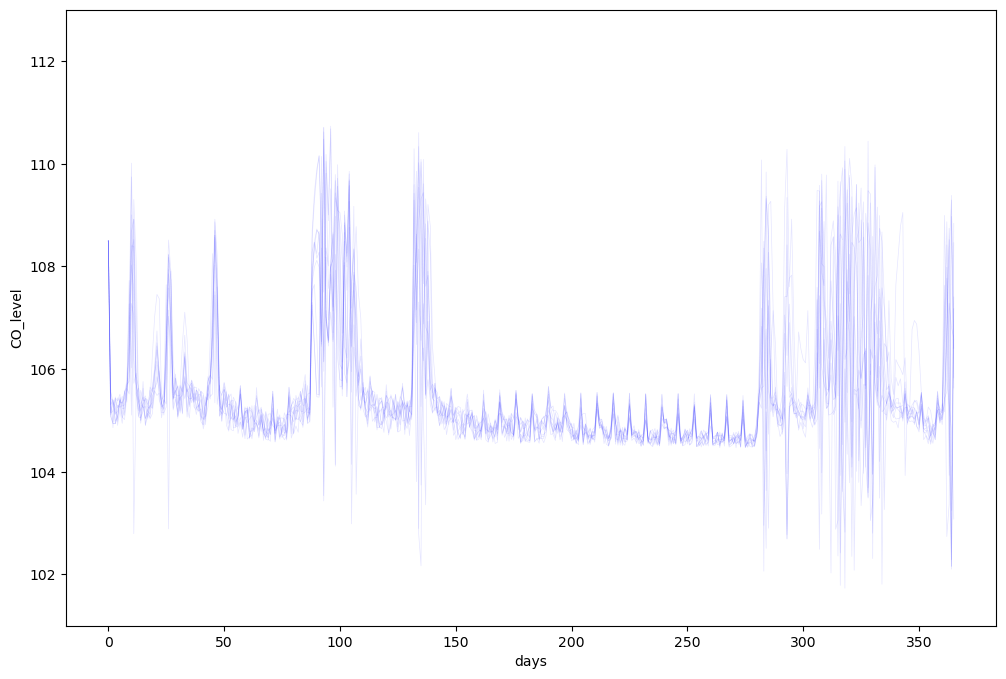

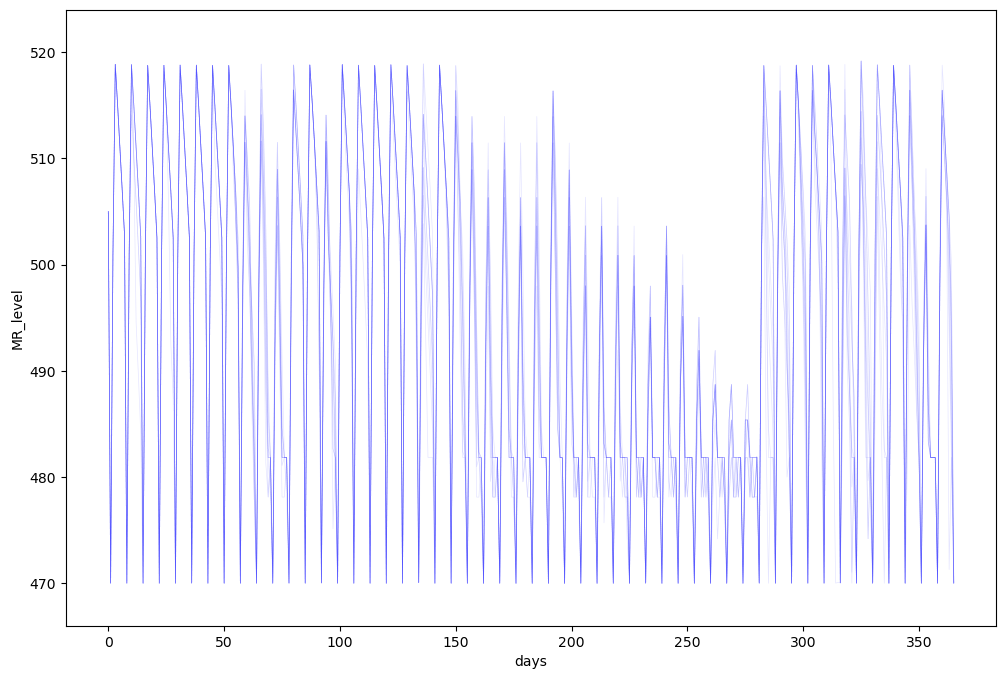

In [21]:

# from susquehanna_model import create_path

if not os.path.exists(f"figs/{name}/releases"):
    os.makedirs(f"figs/{name}/releases")


alpha = 0.1
lw = 0.5
for release in ratom:
    plt.plot(release, "blue", linewidth=lw, alpha=alpha)
    plt.plot(wAtomic, "black", ls="--", linewidth=1)
    plt.xlabel("days")
    plt.ylabel("atom_release")
    plt.ylim((0, 43))
plt.savefig(f"figs/{name}/releases/{name}_ratom.jpg")
plt.show()

for release in rbalt:
    plt.plot(release, "blue", linewidth=lw, alpha=alpha)
    plt.plot(wBaltimore, "black", ls="--", linewidth=1)
    plt.xlabel("days")
    plt.ylabel("baltimore_release")
    plt.ylim((0, 495))
plt.savefig(f"figs/{name}/releases/{name}_rbalt.jpg")
plt.show()

for release in rches:
    plt.plot(release, "blue", linewidth=lw, alpha=alpha)
    plt.plot(wChester, "black", ls="--", linewidth=1)
    plt.xlabel("days")
    plt.ylabel("chester_release")
    plt.ylim((0, 57))
plt.savefig(f"figs/{name}/releases/{name}_rches.jpg")
plt.show()

for release in renv:
    plt.plot(release, "blue", linewidth=lw, alpha=alpha)
    plt.plot(salinity_min_flow_req, "black", ls="--", linewidth=1)
#    plt.plot(min_flow_req, "black", ls="--", linewidth=1)
    plt.xlabel("days")
    plt.ylabel("environment_release")
    plt.ylim((0, 259000))
plt.savefig(f"figs/{name}/releases/{name}_renv.jpg")
plt.show()

for year in level_CO:
    plt.plot(year, "blue", linewidth=lw, alpha=alpha)
    plt.xlabel("days")
    plt.ylabel("CO_level")
    plt.ylim((101, 113))
plt.savefig(f"figs/{name}/releases/{name}_levelco.jpg")
plt.show()

for year in level_MR:
    plt.plot(year, "blue", linewidth=lw, alpha=alpha)
    plt.xlabel("days")
    plt.ylabel("MR_level")
    plt.ylim((466, 524))
plt.savefig(f"figs/{name}/releases/{name}_levelmr.jpg")
plt.show()


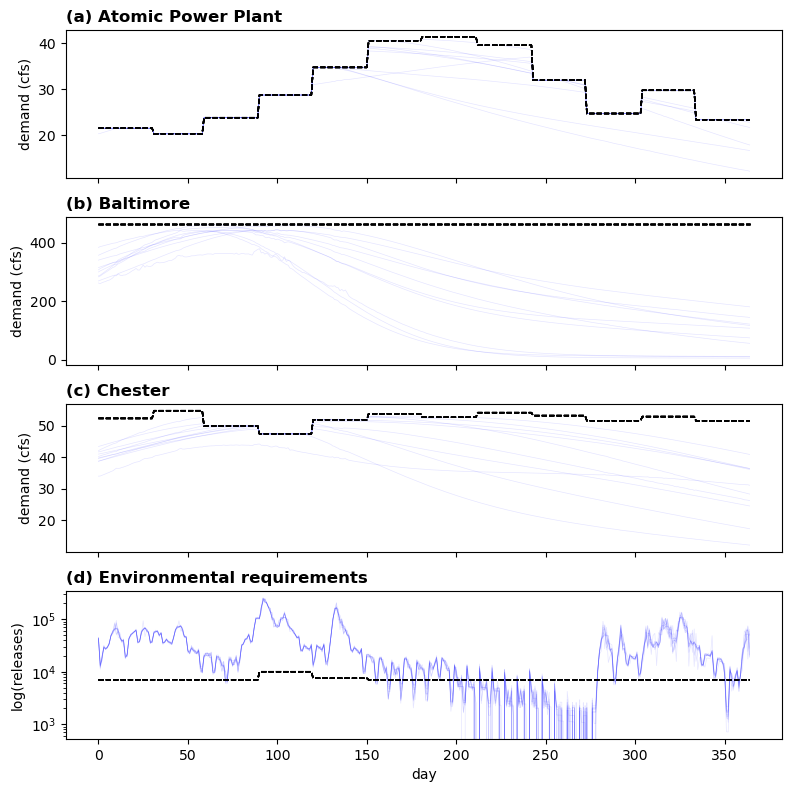

In [7]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 8))  #
for release in ratom:
    ax[0].plot(release, "blue", linewidth=lw, alpha=alpha)
    ax[0].plot(wAtomic, "black", ls="--", linewidth=1)
    ax[0].set_title("(a) Atomic Power Plant", loc="left", weight="bold")
    ax[0].set_ylabel("demand (cfs)")
for release in rbalt:
    ax[1].plot(release, "blue", linewidth=lw, alpha=alpha)
    ax[1].plot(wBaltimore, "black", ls="--", linewidth=1)
    ax[1].set_title("(b) Baltimore", loc="left", weight="bold")
    ax[1].set_ylabel("demand (cfs)")
for release in rches:
    ax[2].plot(release, "blue", linewidth=lw, alpha=alpha)
    ax[2].plot(wChester, "black", ls="--", linewidth=1)
    ax[2].set_title("(c) Chester", loc="left", weight="bold")
    ax[2].set_ylabel("demand (cfs)")
for release in renv:
    ax[3].plot(release, "blue", linewidth=lw, alpha=alpha)
    ax[3].plot(salinity_min_flow_req, "black", ls = "--", linewidth=1)
#    ax[3].plot(min_flow_req, "black", ls = "--", linewidth=1)
    ax[3].set_ylabel("log(releases)")
    ax[3].set_title("(d) Environmental requirements", loc="left", weight="bold")
    #     ax[3].set_title("x$10^3$", loc='left')
    ax[3].set_yscale("log")
    ax[3].set_xlabel("day")
fig.tight_layout(pad=1.0)

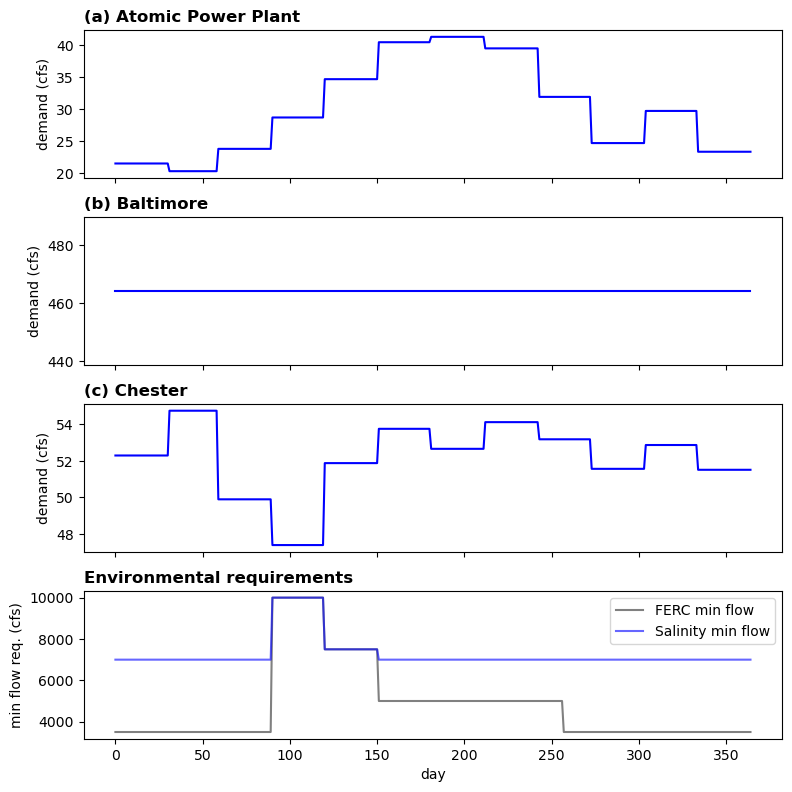

In [31]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 8))  #

ax[0].plot(wAtomic, "blue")
ax[0].set_ylabel("demand (cfs)")
ax[0].set_title("(a) Atomic Power Plant", loc="left", weight="bold")
ax[1].plot(wBaltimore, "blue")
ax[1].set_ylabel("demand (cfs)")
ax[1].set_title("(b) Baltimore", loc="left", weight="bold")
ax[2].plot(wChester, "blue")
ax[2].set_ylabel("demand (cfs)")
ax[2].set_title("(c) Chester", loc="left", weight="bold")
ax[3].plot(min_flow_req, "grey", alpha = 1, label = 'FERC min flow')
ax[3].plot(salinity_min_flow_req, "blue", alpha = 0.6, label = 'Salinity min flow')
ax[3].legend()
ax[3].set_ylabel("min flow req. (cfs)")
ax[3].set_title("Environmental requirements", loc="left", weight="bold")
ax[3].set_xlabel("day")
fig.tight_layout(pad=1.0)

# plot = plt.plot(wAtomic, "blue")
# plot = plt.plot(wBaltimore, "blue")
# plot = plt.plot(wChester, "blue")
# plot = plt.plot(min_flow_req, "blue")

plt.savefig("figs/release_requirements.svg")

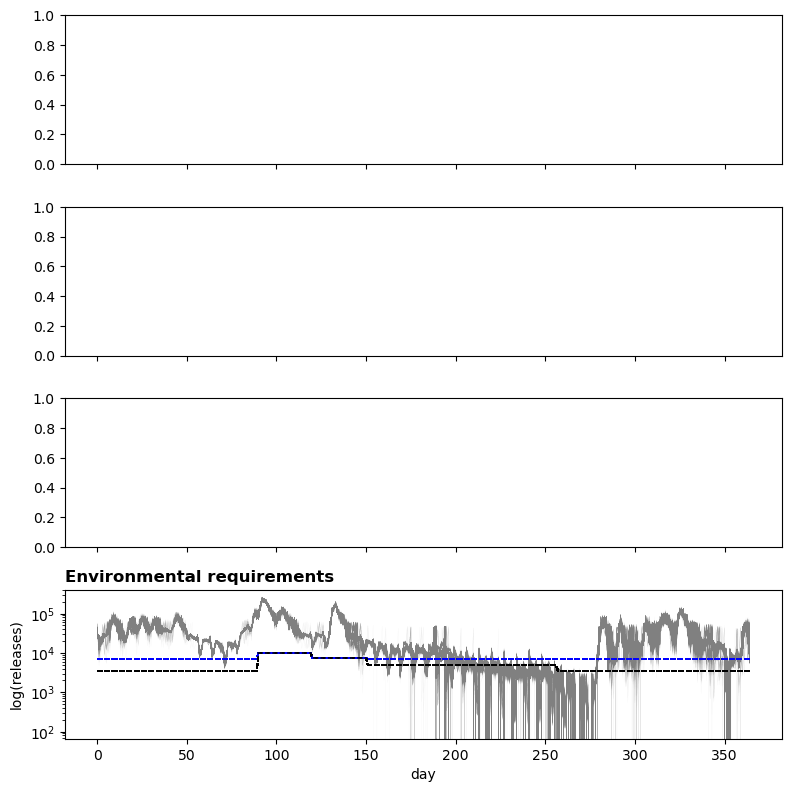

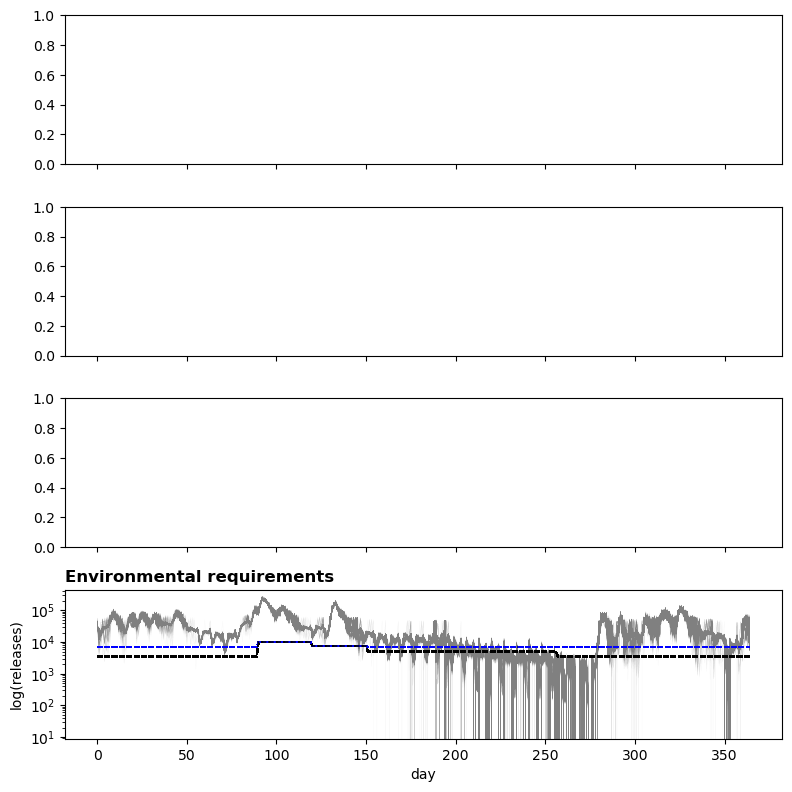

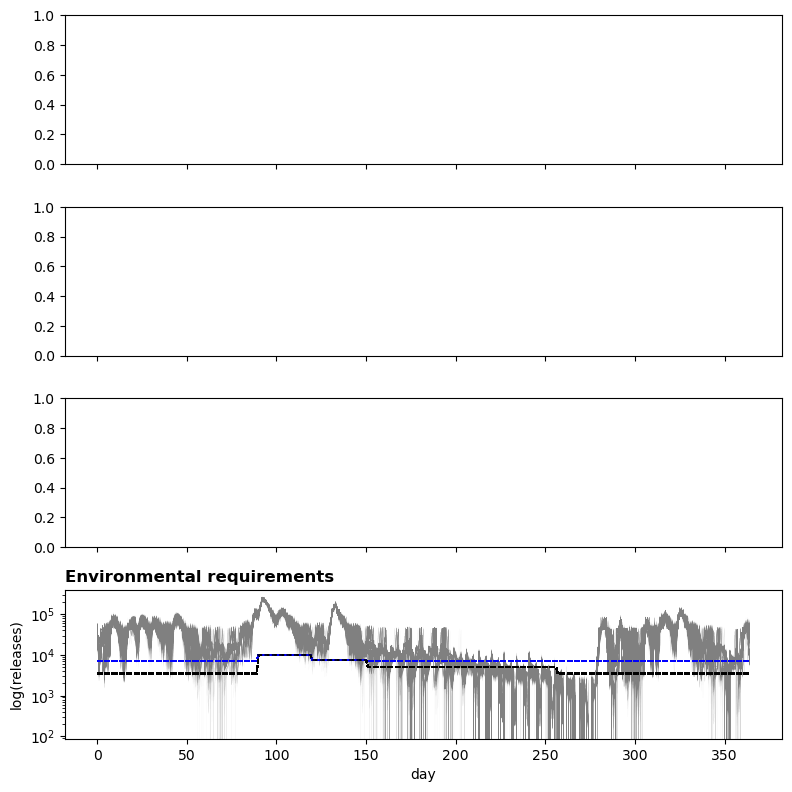

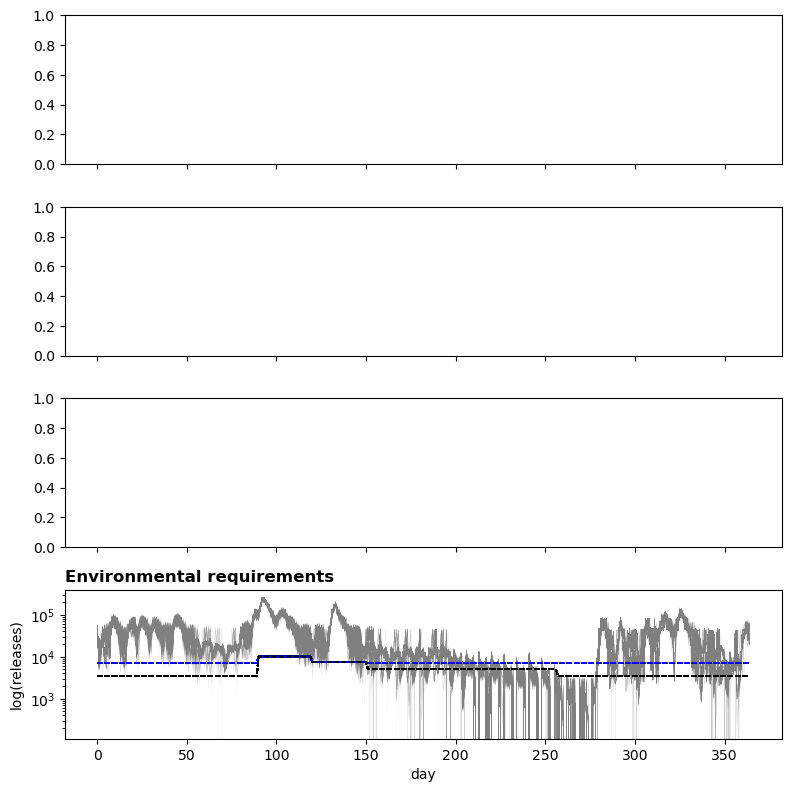

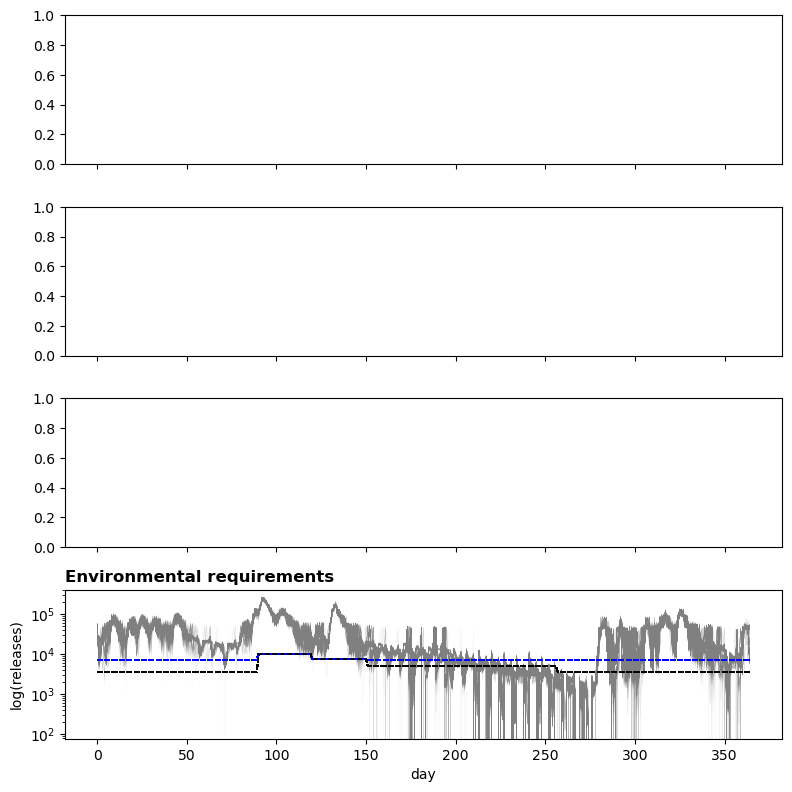

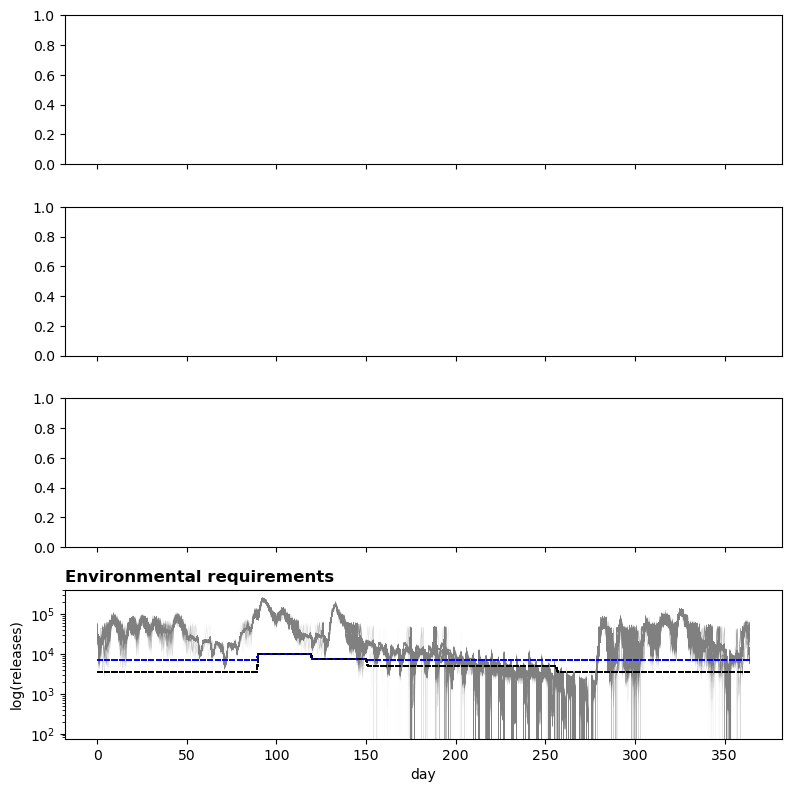

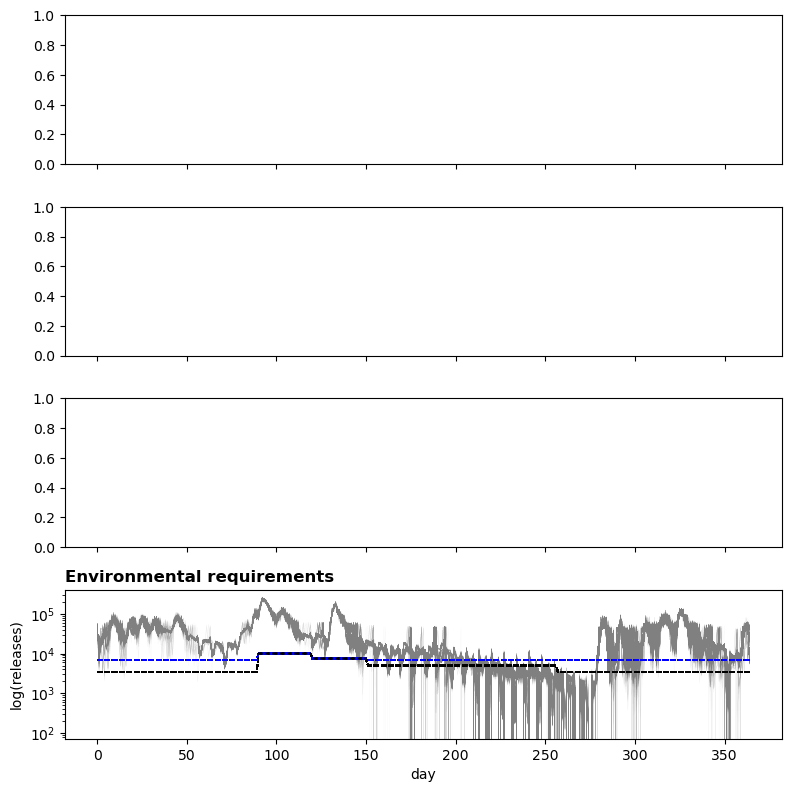

In [41]:
import seaborn as sns

alpha = 0.1
lw = 0.3

#initialize differnt RBF functions to evaluate

for entry, color in zip(rbfs, sns.color_palette()):
    name = entry.__name__
    reference_set = reference_sets[name]

    numberOfRBF = 6  # numberOfInput + 2
    n_inputs = 2  # (time, storage of Conowingo)
    n_outputs = (
        4  # Atomic, Baltimore, Chester, Downstream:- (hydropower, environmental)
    )
    n_rbfs = n_inputs + 2
    rbf = rbf_functions.RBF(n_rbfs, n_inputs, n_outputs, rbf_function=entry)

    # Initialize model
    nobjs = 6
    n_years = 1
    susquehanna_river = SusquehannaModel(
        108.5, 505.0, 5, n_years, rbf
    )  # l0, l0_MR, d0, years
    susquehanna_river.set_log(True)

    for _, row in reference_set.iloc[:, 0:32].iterrows():
        susquehanna_river.evaluate(row) #model is evaluated for each row of the reference set

    level_CO, level_MR, ratom, rbalt, rches, renv = susquehanna_river.get_log() #outputs of the model are retrieved

    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 8))  #

    #wAtomic, wBaltimore, wChester are the water demands before optimization. Black dashed lines
    
    #for release in ratom: #plot model release data. This is simulated release data, not optimized.
    #    ax = axes[0]
    #    ax.plot(release, c=color, linewidth=lw, alpha=alpha)
    #    ax.plot(wAtomic, "black", ls="--", linewidth=1) #plot non-optimized demand level 
    #    ax.set_title("(a) Atomic Power Plant", loc="left", weight="bold")
    #    ax.set_ylabel("demand (cfs)")
    #for release in rbalt:
    #    ax = axes[1]
    #    ax.plot(release, c=color, linewidth=lw, alpha=alpha)
    #    ax.plot(wBaltimore, "black", ls="--", linewidth=1)
    #    ax.set_title("(b) Baltimore", loc="left", weight="bold")
    #    ax.set_ylabel("demand (cfs)")
    #for release in rches:
    #    ax = axes[2]
    #    ax.plot(release, c=color, linewidth=lw, alpha=alpha)
    #    ax.plot(wChester, "black", ls="--", linewidth=1)
    #    ax.set_title("(c) Chester", loc="left", weight="bold")
    #    ax.set_ylabel("demand (cfs)")
    for release in renv:
        ax = axes[3]
        ax.plot(release, c='grey', linewidth=lw, alpha=0.05, label = "release")
        ax.plot(salinity_min_flow_req, "blue", ls="--", linewidth=1, label = "salinity")
        ax.plot(min_flow_req, "black", ls="--", linewidth=1, label = "FERC only")
        ax.set_ylabel("log(releases)")
        ax.set_title("Environmental requirements", loc="left", weight="bold")
        ax.set_yscale("log")
        ax.set_xlabel("day")
    fig.tight_layout(pad=1.0)
    plt.savefig(f"figs/{name}/{name}_releases.svg")
    plt.show()

# quick check of decision variables

It is notable how the poorly performing RBFs struggle with the more or less flat demand profiles. Is this due to artificial limits on the decision variables?

We can quickly visualize othe decision variables using a parallel coordinate system

In [ ]:
from ema_workbench.analysis import parcoords


for entry, color in zip(rbfs, sns.color_palette()):
    name = entry.__name__
    reference_set = reference_sets[name]

    numberOfRBF = 6  # numberOfInput + 2
    n_inputs = 2  # (time, storage of Conowingo)
    n_outputs = (
        4  # Atomic, Baltimore, Chester, Downstream:- (hydropower, environmental)
    )
    n_rbfs = n_inputs + 2
    rbf = rbf_functions.RBF(n_rbfs, n_inputs, n_outputs, rbf_function=entry)

    data = reference_set.iloc[:, 0:32]
    limits = parcoords.get_limits(data)
    limits.iloc[:, rbf.c_i] = np.asarray([-1, 1]).T[:, np.newaxis]
    limits.iloc[:, rbf.r_i] = np.asarray([0, 1]).T[:, np.newaxis]

    parplot = parcoords.ParallelAxes(limits)
    parplot.plot(data, color=color, lw=0.1, alpha=0.2)
    plt.show()